# **Demographic Impact on the Mental Health of Employees**

## Analysis Based On Technology Sectors Employee  Survey

## Introduction

The analysis goal is to understand how can demography can impact mental health issues of employees in the technology sector.

Key questions I will try to answer :

**What percentage of individuals working in the technology sector has mental health disorders?**

**Is there a link between location (country, state) and the mental conditions reported?**

**How do mental health conditions numbers vary across different gender groups?**

**Which age are the most likely to have mental disorder?**

**Is there much of negative stigma overall in the workplaces towards mental conditions ?**

**What are the most popular mental conditions among employees? Are these conditions types can be affected by demografic factors?**


Analysis structure :

1. Introduction

2. Data cleaning

3. General overview of the survey and timeline

4. Demografic distribution

5. Relationship between mental disorders and demografic factors

6. Analysis of perceptions of workplace stigma

7. Deeper analysis of diagnosed respondents expecting negative workplace stigma and demografic factors

8. Analysis conclusion

9. Thoughts on how this analysis could be better


Answering these questions can provide insights into which groups might need targeted mental health interventions.

Importing libraries :

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
import statsmodels.stats.proportion as smp

from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Dict, Optional, Any
from matplotlib.patches import Patch

from MentalHealthCustomFunctionsDictionaries import (
    filter_unrealistic_ages,
    question_mapping,
    gender_mapping,
    country_mapping,
    condition_mapping,
    plot_age_boxplot,
    plot_age_distribution_all_years,
    plot_gender_distribution_all_years,
    categorize_condition,
    generate_age_conditions_contingency_heatmap_2016,
    generate_normalized_age_conditions_heatmap_2016,
    plot_answers_by_year,
    unique_questions_per_year,
    plot_unique_respondents_by_year,
    count_unique_genders_2016,
    count_men_conditions_2016,
    count_women_conditions_2016,
    count_other_gender_conditions_2016,
    plot_multibar_conditions_2016,
    plot_multibar_conditions_percentage_2016,
    plot_us_state_distribution_map_all_years,
    plot_global_country_distribution_all_years,
    plot_mental_health_conditions_with_CI_2016,
    rank_top_20_categorized_conditions_2016,
    rank_top_20_conditions_across_states_2016,
    get_state_data,
    plot_question_114_2016_distribution,
    plot_question_116_conditions_horizontal,
    generate_age_question33_contingency_heatmap_all_year,
    generate_normalized_age_question33_heatmap_all_years,
    plot_multibar_question33_by_gender_all_years,
    plot_multibar_question33_by_gender_percentage_all_years,
    plot_us_state_distribution_map_all_years_question33,
    plot_us_state_most_common_answer_q33,
    plot_question_33_bar,
    plot_global_country_most_common_answer_q33,
    compare_us_vs_eu_mental_health_q33_sql,
)

Defining the database :

In [2]:
db_path = "mental_health.sqlite"

Establishing a connection to a SQLite database and creating a cursor object to interact with it. The cursor is like a handle that you use to execute SQL queries and fetch results from the database :

In [3]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

Using a context manager to automatically close the connection. When the code block within the with statement will be exited, the connection will be automatically closed, even if the errors occur :

In [4]:
with sqlite3.connect(db_path) as conn:
    cursor = conn.cursor()

## Data Cleaning

Fetching all table names :

In [5]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
table_names = [table[0] for table in tables]
print("Tables in database:", table_names)

Tables in database: ['Answer', 'Question', 'Survey']


Previewing each table's schema (PRAGMA table_info (table_name) - retrieves metadata about a table, including information about its columns) :

In [6]:
for table in table_names:
    print(f"\nSchema of {table}:")
    cursor.execute(f"PRAGMA table_info({table});")
    schema = cursor.fetchall()
    for column in schema:
        print(column)


Schema of Answer:
(0, 'AnswerText', 'VARCHAR(10000)', 0, None, 0)
(1, 'SurveyID', 'INTEGER', 0, None, 0)
(2, 'UserID', 'INTEGER', 0, None, 0)
(3, 'QuestionID', 'INTEGER', 0, None, 0)

Schema of Question:
(0, 'questiontext', 'VARCHAR(1000)', 0, None, 0)
(1, 'questionid', 'INTEGER', 0, None, 0)

Schema of Survey:
(0, 'SurveyID', 'INTEGER', 1, None, 1)
(1, 'Description', 'VARCHAR(255)', 0, None, 0)


Reading the data from three different tables in a SQLite database and loading them into the pandas :

In [7]:
answer_df = pd.read_sql("SELECT * FROM Answer", conn)
question_df = pd.read_sql("SELECT * FROM Question", conn)
survey_df = pd.read_sql("SELECT * FROM Survey", conn)

Merging tables to create a full dataset. This combines related data, makes it easier to analyze and understand it :

In [8]:
merged_df = answer_df.merge(
    question_df, left_on="QuestionID", right_on="questionid", how="left"
).merge(survey_df, on="SurveyID", how="left")

Standardizing and grouping similar questions across survey years. This is a crucial step in data cleaning and preparation, especially when dealing with survey data where questions might be phrased differently but essentially ask the same thing. It also gives more data consistency and code readibility (using dictionary from a supportive file) :

In [9]:
merged_df["questiontext"] = merged_df["questiontext"].replace(question_mapping)

Dealing with missing data. Filling any missing values (NaN) in the AnswerText column of merged_df with the string "Not Provided" :

In [10]:
merged_df["AnswerText"] = merged_df["AnswerText"].fillna("Not Provided")

Converting age to numeric. This is a crucial step to ensure performing numerical operations on the age data.:

In [11]:
merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"] = pd.to_numeric(
    merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"], errors="coerce"
)

Taking a closer look at the age outliers with box plot (function from a supportive file): 

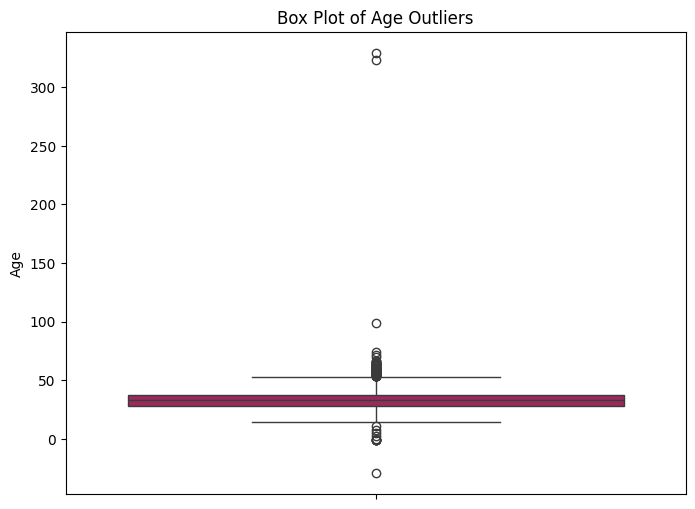

In [12]:
plot_age_boxplot(merged_df)

It seems that there's some unrealistic ages like the one's above 100 and below 0 we should remove them.

Converting 'AnswerText' related to age to a numeric (Without errors="coerce", pd.to_numeric() would raise a ValueError). The code snippet extracts the "AnswerText" values related to "Age", attempts to convert them to numbers, and replaces any non-convertible values with NaN.  The result is stored in temp_age_numeric :

In [13]:
temp_age_numeric = pd.to_numeric(
    merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"], errors="coerce"
)

Detecting and replacing outliers, ensuring negative ages and unrealistically old ages are handled. Using function filter_unrealistic_ages that filters out unlikely age values from a Pandas Series, replacing them with NaN :

In [14]:
temp_age_numeric_cleaned = filter_unrealistic_ages(
    temp_age_numeric, min_age=0, max_age=100
)
merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"] = (
    temp_age_numeric_cleaned.fillna("Not Provided")
)

Isolating the age data, removing missing values :

In [15]:
age_series = merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"].dropna()

Age data processing and categorization :
1. Converts the age_series to numeric (errors="coerce" forces any non-numeric values to become NaN). Removes any NaN values that might have resulted from the previous conversion, ensuring only numbers should be staying.
2. Creating "Age group" column in the age_series after all cleaning and processing. Two lists with labels and bins are created as well. Bins defines age ranges groups.
3. Checking unique values.

In [16]:
age_series = pd.to_numeric(age_series, errors="coerce").dropna()

if not age_series.empty:
    merged_df.loc[merged_df["questiontext"] == "Age", "Age Group"] = pd.cut(
        age_series,
        bins=[0, 19, 29, 39, 49, 59, 100],
        labels=["<20", "20-29", "30-39", "40-49", "50-59", "60+"],
        right=False,
    )
else:
    merged_df.loc[merged_df["questiontext"] == "Age", "Age Group"] = "Not Provided"

print(age_series.unique())

[37. 44. 32. 31. 33. 35. 39. 42. 23. 29. 36. 27. 46. 41. 34. 30. 40. 38.
 50. 24. 18. 28. 26. 22. 19. 25. 45. 21. 43. 56. 60. 54. 55. 48. 20. 57.
 58. 47. 62. 51. 65. 49.  5. 53. 61.  8. 11. 72. 52. 17. 63. 99.  3. 66.
 59. 15. 74. 70. 64. 67.  0.]


Checking the situation with genders :

In [17]:
raw_genders = merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"]
print("Raw Unique Genders Before Mapping:", raw_genders.unique())

Raw Unique Genders Before Mapping: ['Female' 'Male' 'Male-ish' 'Trans-female' 'something kinda male?'
 'queer/she/they' 'non-binary' 'Nah' 'All' 'Enby' 'fluid' 'Genderqueer'
 'Androgyne' 'Agender' 'Guy (-ish) ^_^' 'male leaning androgynous'
 'Trans woman' 'Neuter' 'Female (trans)' 'queer' 'A little about you' 'p'
 'ostensibly male, unsure what that really means' 'Bigender'
 'Female assigned at birth' 'fm' 'Transitioned, M2F'
 'Genderfluid (born female)' 'Other/Transfeminine'
 'Female or Multi-Gender Femme' 'Androgynous' 'male 9:1 female, roughly'
 '-1' 'Other' 'nb masculine' 'none of your business' 'genderqueer' 'Human'
 'Genderfluid' 'genderqueer woman' 'mtf' 'Queer' 'Fluid'
 'Male/genderqueer' 'Nonbinary' 'human' 'Unicorn' 'Male (trans, FtM)'
 'Genderflux demi-girl' 'female-bodied; no feelings about gender' 'AFAB'
 'Transgender woman' 'male' 'female' 'male/androgynous'
 'uhhhhhhhhh fem genderqueer?' 'God King of the Valajar' 'Non-binary'
 'Agender/genderfluid' 'sometimes' 'Woman-iden

Gender mapping, standardizing gender responses. Code addresses potential inconsistencies in how people might input their gender, ensuring uniformity for analysis (using dictionary from a supportive file) :

In [18]:
if "Gender" in merged_df["questiontext"].values:

    merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"] = (
        merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"]
        .astype(str)
        .str.strip()
        .str.title()
        .replace(gender_mapping)
    )

    merged_df = merged_df[
        (merged_df["questiontext"] != "-1") & (merged_df["AnswerText"] != "-1")
    ]

    valid_genders = ["Male", "Female", "Other"]
    merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"] = merged_df.loc[
        merged_df["questiontext"] == "Gender", "AnswerText"
    ].apply(lambda x: x if x in valid_genders else "Other")

print(
    "Unique Genders after fixing:",
    merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"].unique(),
)

Unique Genders after fixing: ['Female' 'Male' 'Other']


Standardizing country names for better data consistency. As well there's countries with the same name like United States and United States of America, we have to take care of that using country_mapping dictionary and replace function :


In [19]:
merged_df.loc[merged_df["questiontext"] == "Country", "AnswerText"] = (
    merged_df.loc[merged_df["questiontext"] == "Country", "AnswerText"]
    .str.strip()
    .str.title()
)

merged_df.loc[merged_df["questiontext"] == "Country", "AnswerText"] = merged_df.loc[
    merged_df["questiontext"] == "Country", "AnswerText"
].replace(country_mapping)

 Printing cleaned dataset :

The data on states are not clean, I will have to custom get_state_data function to properly manage it : 

In [20]:
state_data = get_state_data(db_path)

print(state_data.head())

        state  respondent_count
0  California               382
1    Illinois               223
2  Washington               168
3    New York               146
4   Tennessee               121


## General overview of the survey and timeline

Let's check the sample size of the survey :

In [ ]:
unique_users = merged_df["UserID"].nunique()
print(f"Total unique respondents: {unique_users}")

Total unique respondents: 4218


Number of given answers during the 2014 - 2019 period :

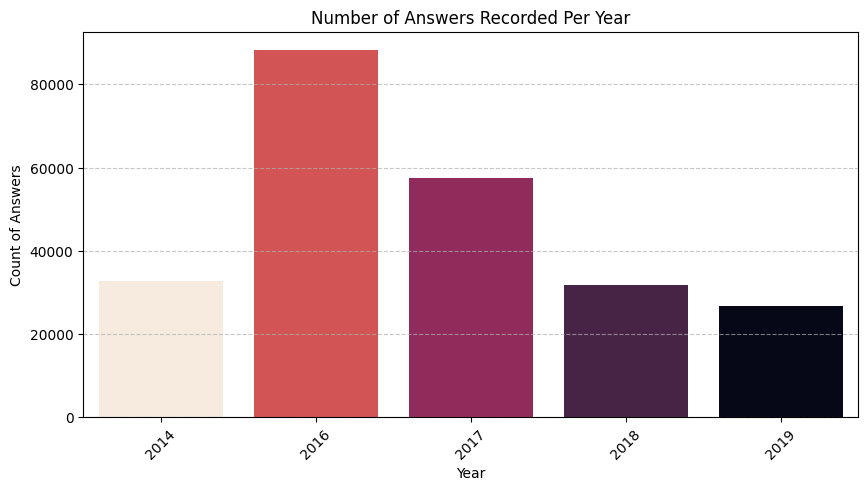

,Year,AnswerCount
0,2014,32760
1,2016,88238
2,2017,57456
3,2018,31692
4,2019,26752


In [22]:
(plot_answers_by_year)(db_path)

The data shows the decline in answer count since 2016 and missing answer data from 2015, indicating that survey wasn't active during 2015 period.

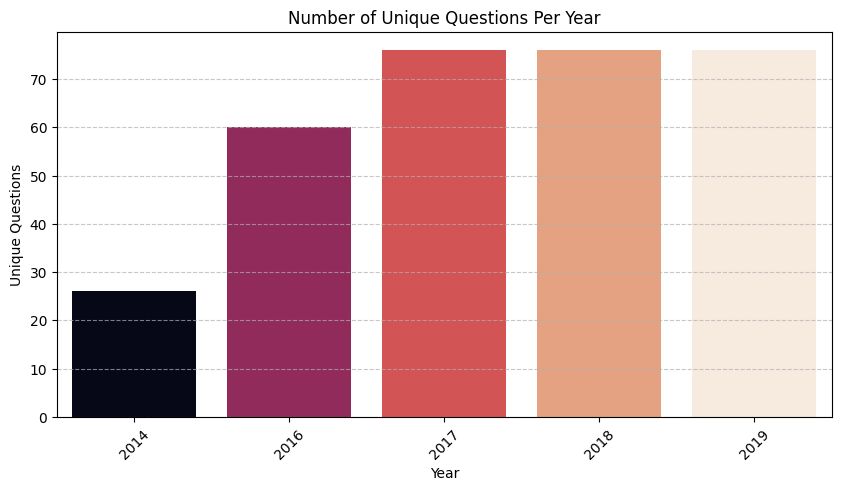

,Year,UniqueQuestions
0,2014,26
1,2016,60
2,2017,76
3,2018,76
4,2019,76


In [23]:
unique_questions_per_year(db_path)

Number of questions through out the years grew reaching 76 unique question limit since 2017. It indicates that questions varies and might be different through out the years.

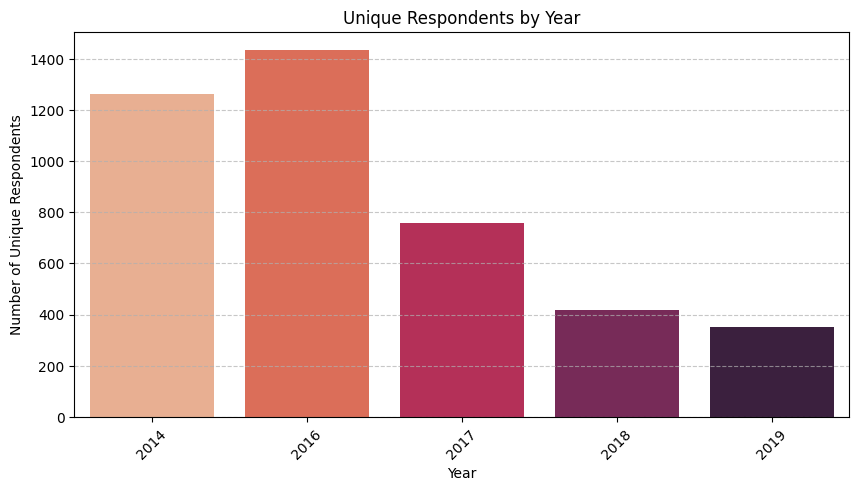

In [24]:
unique_users_by_year_df = plot_unique_respondents_by_year(db_path)

Unique respondants peaks at 2016 and gets smaller every year until the end of survey 2019. 

##  Demographic Distribution    

The bar chart categorizes respondents into six age groups:

<20 (Younger respondents)
20-29 (Early-career professionals or students)
30-39 (Mid-career professionals)
40-49 (Experienced professionals)
50-59 (Late-career professionals)
60+ (Retired or senior professionals)

Visualizing results with a bar chart :

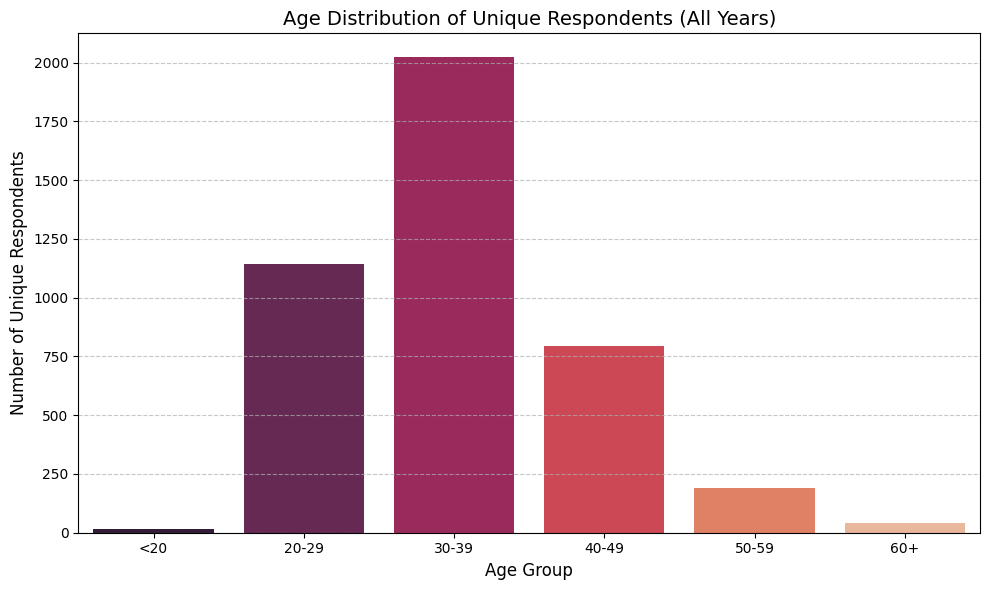

Age Group
<20        16
20-29    1143
30-39    2024
40-49     796
50-59     191
60+        40
Name: count, dtype: int64

In [25]:
plot_age_distribution_all_years(merged_df)

The 30-39 age group has the highest participation, reflecting mid-career individuals who may have a vested interest in workplace or mental health discussions.
The 20-29 age group also shows strong participation, likely representing early-career professionals and students who are more engaged in digital platforms and surveys.
Respondents above 50 years old are significantly fewer, which could indicate lower survey reach among older demographics or less willingness to participate.

Visualizing the data :

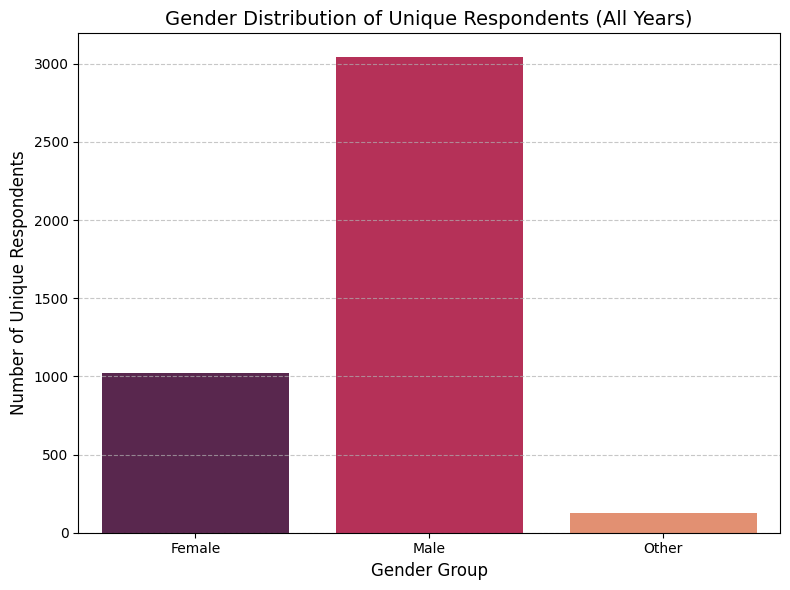

Gender Group
Female    1024
Male      3043
Other      127
Name: count, dtype: int64

In [26]:
plot_gender_distribution_all_years(merged_df)

Male respondents represent the majority, accounting for nearly three-quarters (72.6%) of the sample.

Female respondents make up 24.4% of the participants.

Respondents identifying as Other account for 3.0%, showing representation beyond the traditional gender binary.

What is the geographic distribution of respondents?

The geographic distribution of survey respondents provides a view of regional engagement, but it may also reflect external factors influencing participation.

Key Considerations:

Tech Industry Presence: Higher response rates in certain regions may correlate with tech sector development rather than overall engagement. Areas with a strong technology workforce likely have higher survey visibility.

Survey Outreach Bias: Some regions may show higher participation due to targeted outreach efforts. If the survey was shared more actively in specific countries or states, the data might reflect where respondents were most likely to be reached rather than genuine interest differences.

Language & Accessibility: Lower participation in some regions could be due to language barriers or lack of familiarity with the survey platform, affecting overall representation.

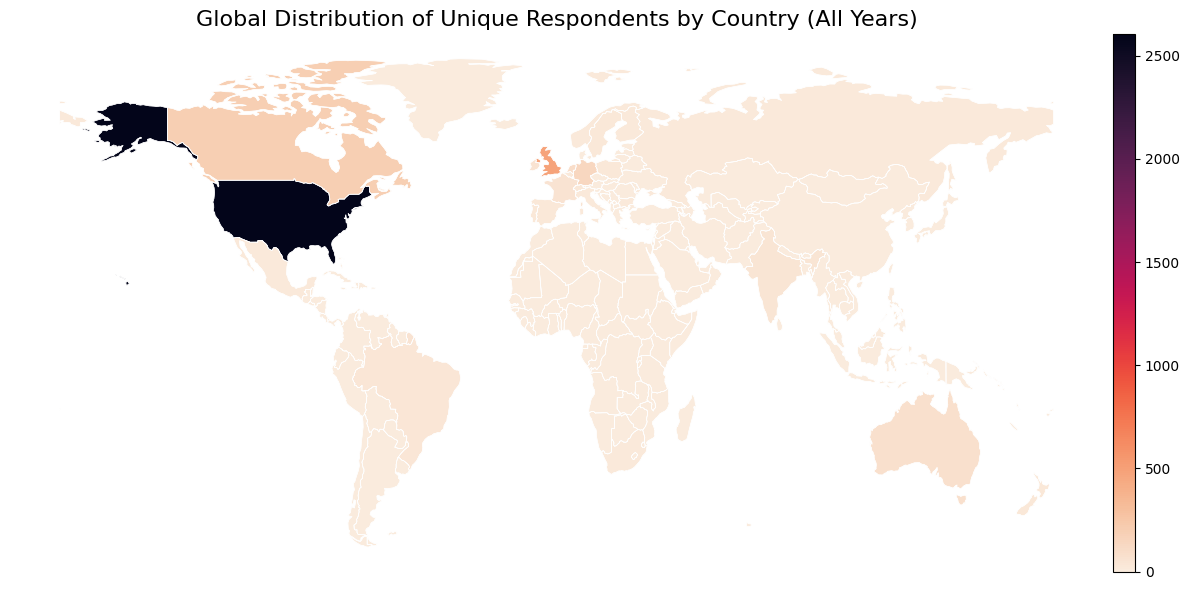

,Country,respondent_count
0,United States Of America,2604
1,United Kingdom,482
2,Canada,199
3,Germany,136
4,Netherlands,98
...,...,...
62,Mauritius,1
61,Jordan,1
60,Kenya,1
59,Belarus,1


In [27]:
shapefile_path = "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"

plot_global_country_distribution_all_years(merged_df, shapefile_path)

World map graph shows that the survey participants were mainly from US, with small of participants being from UK, Germany, Australia and Canada as well.

1. United States - The overwhelming majority of responses came from the U.S., likely due to survey reach, language accessibility, and industry concentration.
USA accounts for the majority of respondents, with 62.1% of the total responses.

2. United Kingdom - A significant number of responses suggest strong awareness or outreach efforts in English-speaking countries. The United Kingdom makes total of 11.5% unique respondants.

3. Canada shows moderate participation, possibly reflecting their tech industry engagement (4.7% of all respondants).

4. Low-Participation Countries (≤0.02%) - Countries like Ethiopia, Ecuador, Brunei, Belarus, and The Bahamas have minimal engagement, possibly due to limited survey outreach or tech sector presence in these regions. A diverse global reach is observed, with over 60 countries represented, although many have only a single respondent (0.02%).

Let's take a closer look at US and it's states geographic distribution of survey respondents :

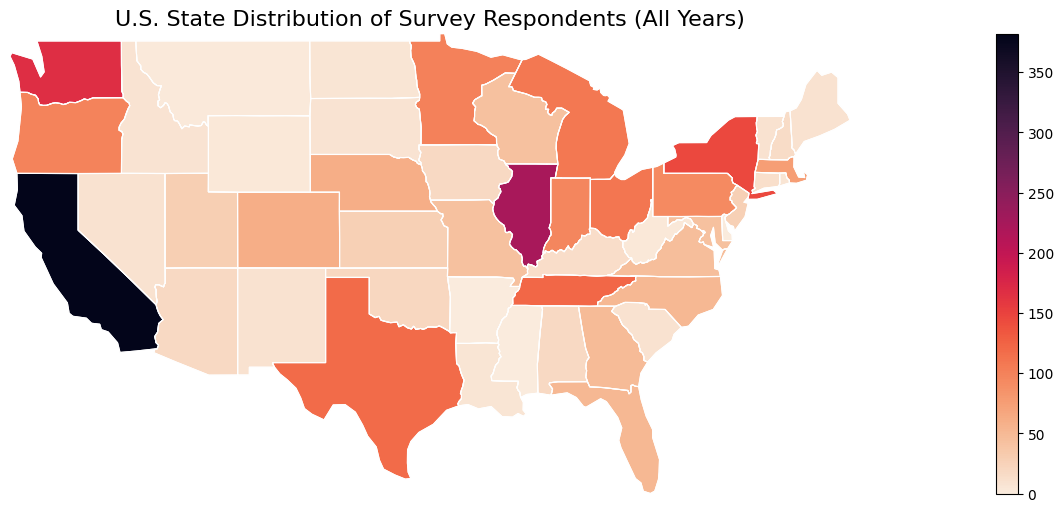

Top 10 States by Respondent Count:

     State  respondent_count
California               382
  Illinois               223
Washington               168
  New York               146
 Tennessee               121
     Texas               119
      Ohio               109
  Michigan               108
 Minnesota               101
    Oregon                99


In [28]:
shapefile_path = "ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp"

plot_us_state_distribution_map_all_years(merged_df, shapefile_path)

California has the largest share of respondents at 20.0%, making up one-fifth of the total U.S. dataset. This aligns with its position as a major tech and corporate hub, where workplace mental health discussions are more prevalent.

Other highly represented states include Illinois (11.7%) and Washington (8.8%), reflecting high concentrations of professionals in urban areas and industries where mental health awareness is growing.

The top 10 states together account for a large proportion of the total respondents.

Texas and Florida, despite having large populations, show relatively lower response rates, suggesting possible regional differences in survey outreach or awareness.

Lower participation states (e.g., Montana, Mississippi, Delaware) make up a very small percentage of responses, likely due to lower survey visibility in these regions or differences in workplace culture.

Additional insights :

1. Higher participation in states with strong tech, finance, and corporate presence suggests that workplace mental health awareness may be more developed in these regions.

2. Lower engagement in some states could indicate gaps in awareness, industry representation, or outreach strategies.

3. Future surveys should consider targeted outreach in lower-participation states to improve geographic representation.

## Relationship Between Mental Disorders And Demografic Factors

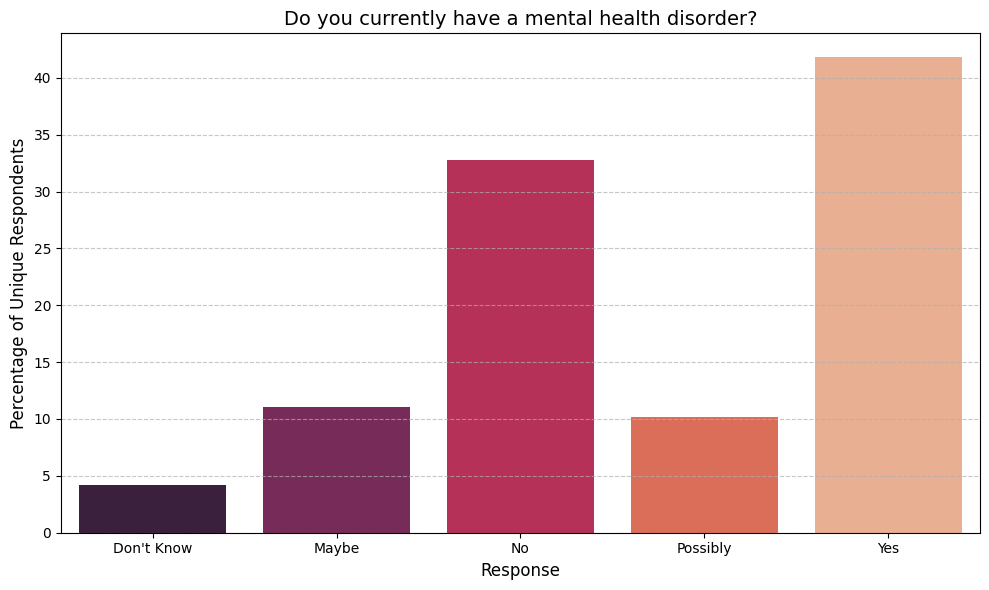

In [29]:
plot_question_33_bar(merged_df)

41.8% of respondents report currently having a mental health disorder, highlighting its prevalence in the workplace.

21.3% expressed uncertainty ("Maybe" or "Possibly"), suggesting gaps in awareness or access to diagnosis.

4.2% answered "Don't know", indicating a need for better mental health education.

32.8% reported no current mental health disorder, but preventive measures remain important.

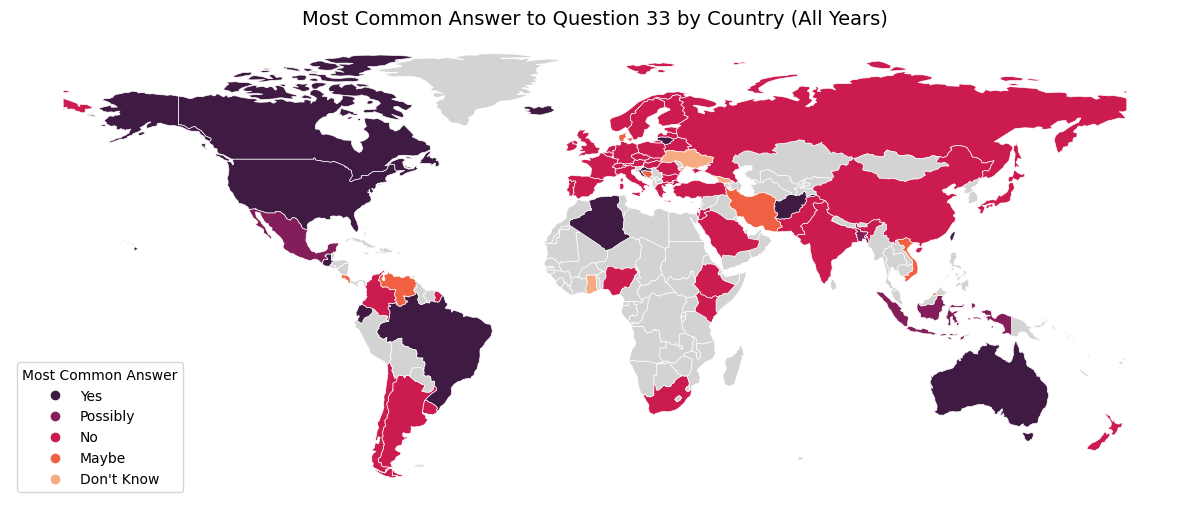

In [ ]:
shapefile_path = "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"

result = plot_global_country_most_common_answer_q33(merged_df, shapefile_path)

United States, Canada, and Australia show "Yes" as the most common answer, indicating greater openness in discussing mental health at work.

Most of Europe responded "No", except for Lithuania, Iceland, and Croatia, which said "Yes". Denmark and Bosnia answered "Maybe", while Ukraine answered "Don't know" (Many of these countries have small respondant small)

South America is mixed, with no clear regional trend.

Most of Asia responded "No", indicating potential stigma or cultural hesitancy.

Many countries had a low number of respondents, so conclusions for those regions should be made cautiously.

From this map, we can see that more people in North America and Australia has mental disorders, than in Europe. The U.S. tech sector is high-pressure, often characterized by long hours, job insecurity, and high expectations, which can contribute to higher stress, anxiety, and depression. Some EU countries have stronger labor protections, shorter workweeks, and better work-life balance that could be a reason for these results.

Now, let's explore US situation more accurately :

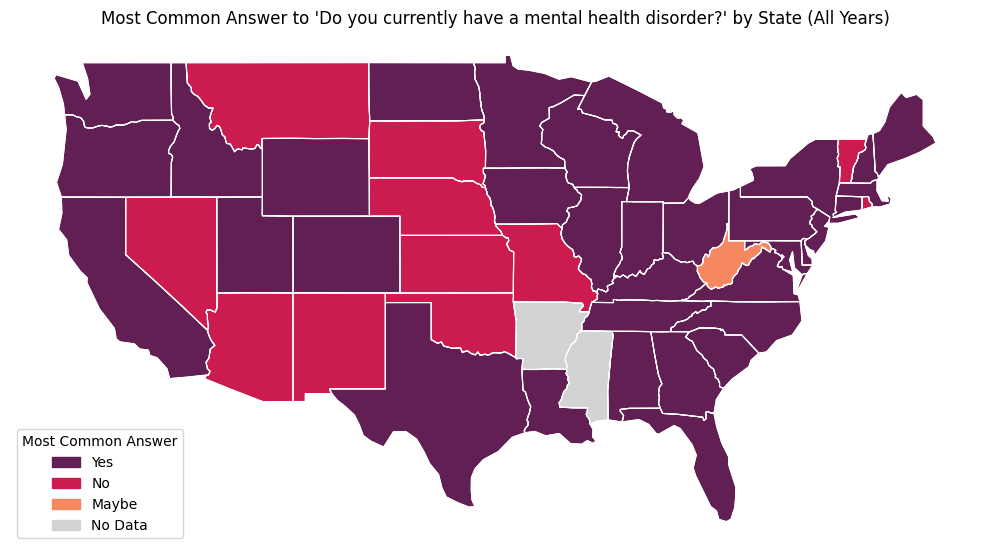

No data for states: ['Arkansas', 'Mississippi']


In [31]:
shapefile_path = "ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp"

plot_us_state_most_common_answer_q33(merged_df, shapefile_path)

Most U.S. states report "Yes" as the most common answer, suggesting widespread acknowledgment of mental health issues.

States like Nebraska, Kansas, and Missouri report "No" more often, possibly reflecting regional differences in stigma or diagnosis.

"Maybe" responses appear only in Alaska (excluded from graph to save space) and West Virginia, indicating uncertainty or limited access to mental health resources.

The portion of Mid West states stands out as their respondants most common answer were negative. 

Respondants from all more developed states where technology coorporations are booming answered positevely.

This suggests a potential link between urban living, economic development, tech industry presence, and more progressive attitudes toward mental health in the workplace.

I want to check if there's a pattern between diffirent gender groups and likeliness of having mental disorder :

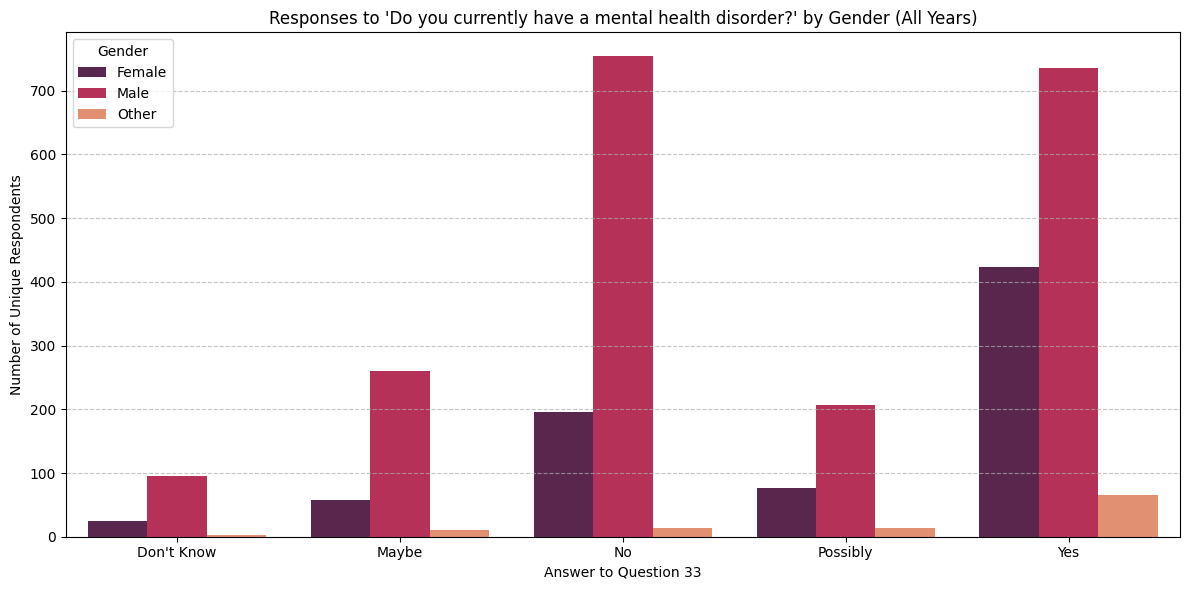

In [32]:
plot_multibar_question33_by_gender_all_years(merged_df)

Let's normalize the date since there's way more men :

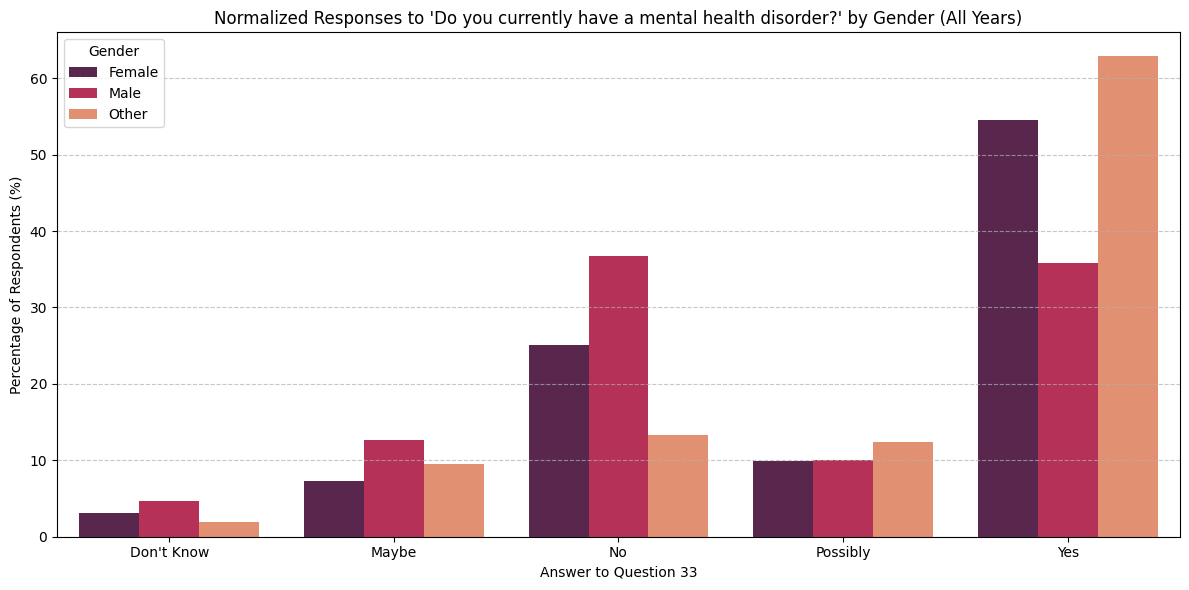


Normalized Percentages by Gender (All Years):

Female:
  Don't Know: 3.09%
  Maybe: 7.34%
  No: 25.10%
  Possibly: 9.91%
  Yes: 54.57%

Male:
  Don't Know: 4.68%
  Maybe: 12.67%
  No: 36.74%
  Possibly: 10.09%
  Yes: 35.82%

Other:
  Don't Know: 1.90%
  Maybe: 9.52%
  No: 13.33%
  Possibly: 12.38%
  Yes: 62.86%



In [33]:
plot_multibar_question33_by_gender_percentage_all_years(merged_df)

Key Insights:

Females report "Yes" at the highest rate among traditional gender groups (54.6%), with relatively low uncertainty ("Don't Know" 3.1%).

Males show a lower "Yes" rate (35.8%) and a higher tendency to respond "No" (36.7%), along with more "Maybe" responses (12.7%).

Other gender respondents report the highest "Yes" rate overall (62.9%) and the lowest "No" rate (13.3%), suggesting a greater self-identification with mental health challenges.


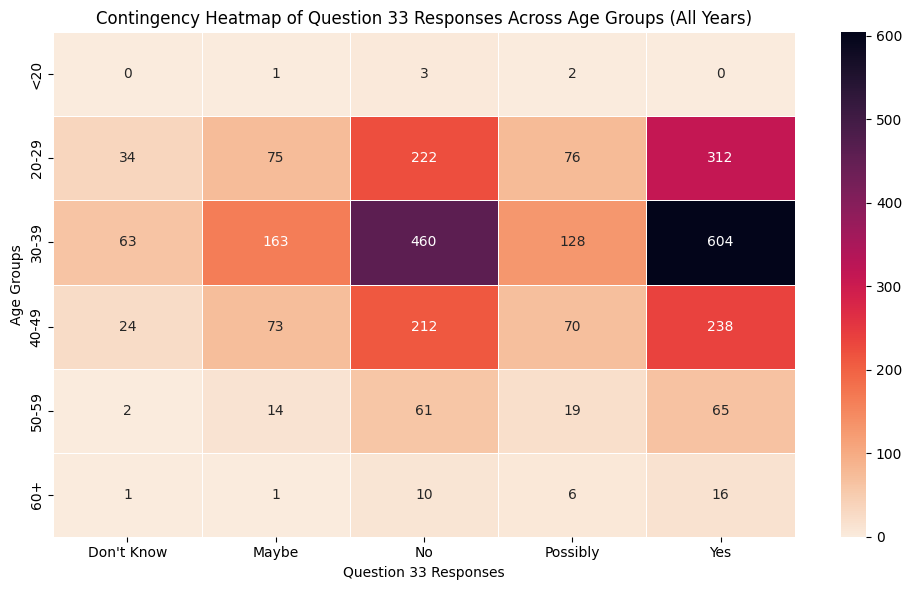

Q33 Answer,Don't Know,Maybe,No,Possibly,Yes
Age Group,,,,,
<20,0,1,3,2,0
20-29,34,75,222,76,312
30-39,63,163,460,128,604
40-49,24,73,212,70,238
50-59,2,14,61,19,65
60+,1,1,10,6,16


In [34]:
generate_age_question33_contingency_heatmap_all_year(merged_df)

The 30-39 and 20-29 age groups report the highest numbers of respondents acknowledging a mental health disorder.

30-39: 604 answered "Yes", showing the highest confirmation rate.
20-29: 312 answered "Yes", following closely behind.
In younger groups:

Respondents under 20 have minimal data, with only a few reporting "Yes" (0) or "Maybe" (1).

Respondents aged 40-49 also show a considerable number reporting "Yes" (238), though slightly less than younger age groups.

Older age groups (50-59 and 60+) show a sharp decline in reported mental health conditions, suggesting:

Lower reported mental health concerns

Possible generational stigma or underdiagnosis

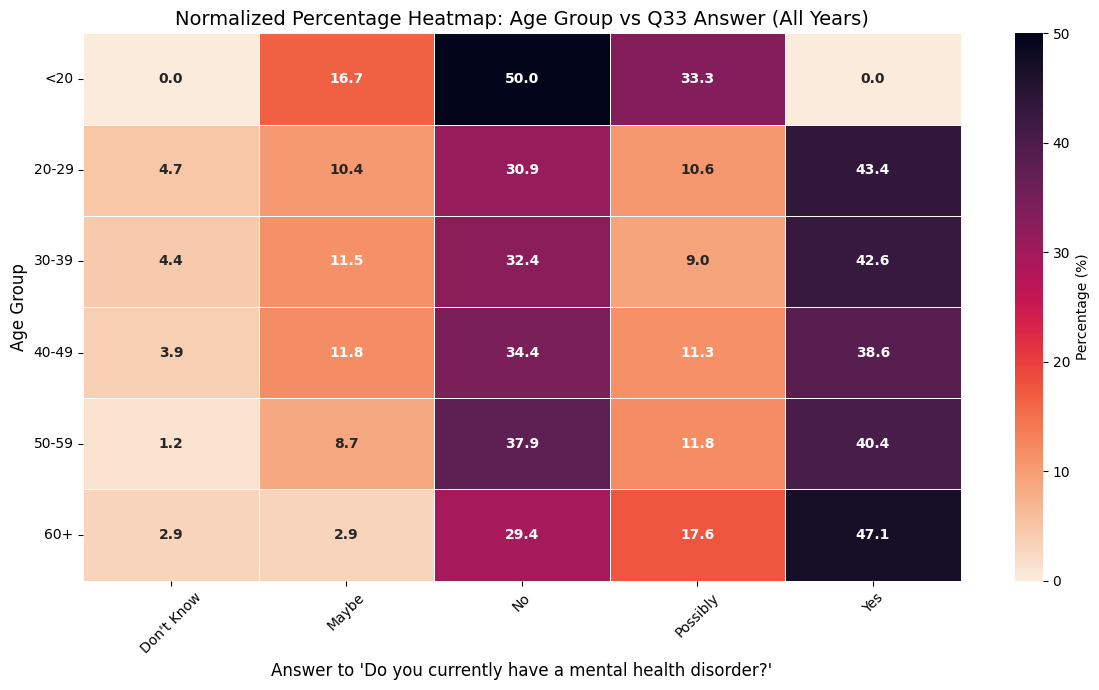

Q33 Answer,Don't Know,Maybe,No,Possibly,Yes
Age Group,,,,,
<20,0.000000,16.666667,50.000000,33.333333,0.000000
20-29,4.728790,10.431154,30.876217,10.570236,43.393602
30-39,4.442877,11.495063,32.440056,9.026798,42.595205
40-49,3.889789,11.831442,34.359806,11.345219,38.573744
50-59,1.242236,8.695652,37.888199,11.801242,40.372671
60+,2.941176,2.941176,29.411765,17.647059,47.058824


In [35]:
generate_normalized_age_question33_heatmap_all_years(merged_df)

Key Insights:

The likelihood of answering "Yes" to having a mental health disorder increases with age, peaking in the 60+ group (47.1%).

Younger respondents, especially under 20, are more likely to respond with uncertainty ("Maybe" 16.7%) or "No" (50%), though the small sample size may affect this.

Middle-aged groups (30-49) show a relatively balanced distribution, with around 32-37% answering "No" and 39-43% answering "Yes".

Respondents aged 50-59 report "Yes" at 40.4%, showing a steady increase from younger cohorts.

"Possibly" and "Don't know" responses remain relatively low across all age groups.

There’s a progressive increase in affirmative diagnoses ("Yes") with age.
Older groups are more certain about their mental health status, while younger groups show greater uncertainty.

## Analysis of Perceptions of Workplace Stigma

To further explore mental well-being in the workplace of technology sector I wanted too see if many of coworkers expect negative reactions if they knew they had been diagnosed with mental condition. Here are the results :

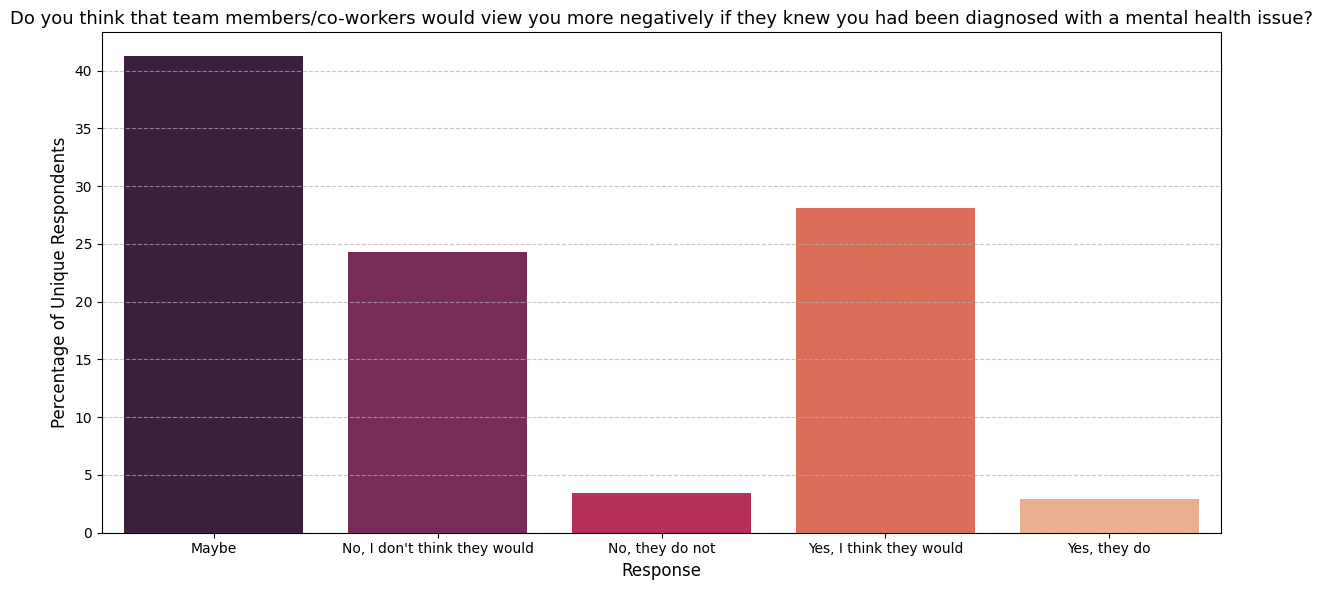

In [36]:
plot_question_114_2016_distribution(merged_df)

Results (2016, Unique Respondents):

- Maybe: 41.2%
- No, I don't think they would: 24.3%
- No, they do not: 3.4%
- Yes, I think they would: 28.1%
- Yes, they do: 2.9%

Summary:
- 31.1% of respondents believe coworkers would view them negatively.
- 27.7% believe they would not be viewed negatively.
- 41.2% are uncertain (responded 'Maybe').

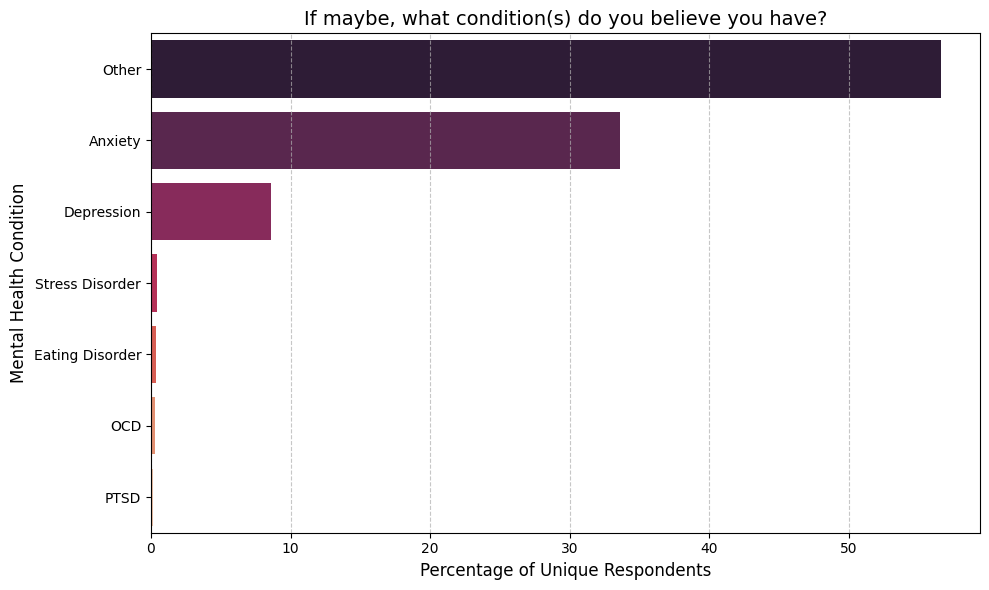


Reported Conditions and Percentages (2016):

- Other: 56.5%
- Anxiety: 33.6%
- Depression: 8.6%
- Stress Disorder: 0.5%
- Eating Disorder: 0.4%
- OCD: 0.3%
- PTSD: 0.2%

Breakdown of 'Other' Conditions (% within 'Other'):

- Etc): 46.7%
- Social: 29.7%
- Bipolar disorder: 15.2%
- Attention deficit hyperactivity disorder: 1.6%
- Paranoid: 1.0%
- Antisocial: 1.0%
- Personality disorder (borderline: 1.0%
- Substance use disorder: 0.8%
- Psychotic disorder (schizophrenia: 0.5%
- Schizoaffective: 0.5%
- Dissociative disorder: 0.3%
- Addictive disorder: 0.3%
- Gender identity disorder: 0.2%
- Burnout: 0.2%
- Right?!: 0.2%
- We're all hurt: 0.2%
- Post-partum: 0.2%
- Anxiety: 0.2%
- Asperger syndrome: 0.2%
- Depersonalization disorder: 0.2%
- Autism: 0.2%


In [37]:
plot_question_116_conditions_horizontal(merged_df, condition_mapping)

The most commonly mental health conditions among respondents who believed they may have a condition were Anxiety (33.6%) and Depression (8.6%), while 56.5% of responses were categorized as Other.

Within the Other group, nearly half of the responses (46.7%) were non-specific entries such as "Etc)", while the remaining included conditions like Social anxiety (29.7%), Bipolar disorder (15.2%), and a range of less frequently mentioned disorders including ADHD, Personality disorders, and Autism.

Understanding the prevalence of diagnosed mental health conditions helps identify the most common disorders among respondents who expects negative stigma from their coworkers. I will focus on mental health diagnoses based on Question 115 "If yes, what condition(s) have you been diagnosed with?", where participants specify their diagnosed conditions.

The bar chart below shows the prevalence of diagnosed mental health conditions, categorized into major disorder types:

Anxiety Disorders - Includes Generalized Anxiety, Social Anxiety, Phobias

Depression - Includes Mood Disorders & Clinical Depression

OCD (Obsessive-Compulsive Disorder)

PTSD (Post-Traumatic Stress Disorder)

Eating Disorders - Includes Anorexia & Bulimia

Stress Disorders - Includes Stress Response Syndromes

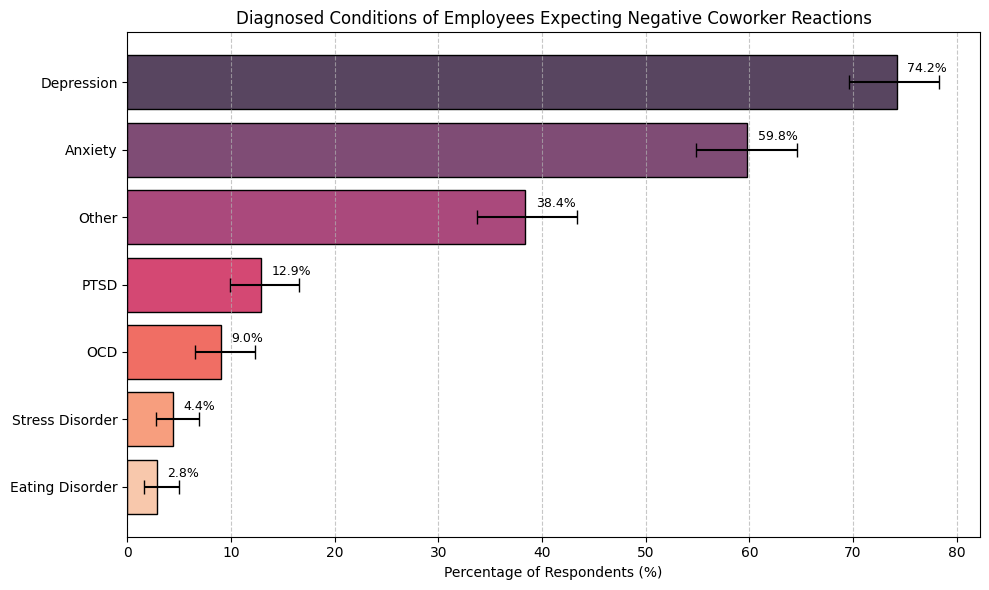

,Category,TotalUsers,Percentage,CI Lower,CI Upper
0,Eating Disorder,11,2.835052,1.590283,5.004593
1,Stress Disorder,17,4.381443,2.753289,6.904050
2,OCD,35,9.020619,6.557557,12.287172
3,PTSD,50,12.886598,9.913099,16.587787
4,Other,149,38.402062,33.698790,43.332737
5,Anxiety,232,59.793814,54.842094,64.553506
6,Depression,288,74.226804,69.652093,78.326495


In [38]:
plot_mental_health_conditions_with_CI_2016(db_path, condition_mapping)

Key Insights :

Depression is the most prevalent condition among respondents who expect negative reactions from coworkers, reported by 74.2% of this group, with a confidence interval between 69.7% and 78.3%.

Anxiety is the second most common condition, affecting 59.8% of these respondents.

38.4% of respondents reported conditions categorized as Other, which includes a variety of additional diagnoses not specified in the primary categories.

Less prevalent conditions, such as PTSD, OCD, Stress Disorders, and Eating Disorders, show significantly lower rates within this group. For example, Eating Disorders were reported by only 2.8% of respondents.

Among all diagnosed respondents who expect negative workplace stigma, 74% reported Depression as one of their conditions.

Uncertainty of this graph :

The uncertainty in these estimates arises because we are working with a small sample of survey respondents, not the entire population of tech employees.

Sampling Bias in This Subgroup - Respondents in this subgroup may:
1. Be more aware of their mental health issues.
2. Have higher rates of conditions like depression or anxiety compared to the general survey population.

Different samples might give slightly different percentages depending on who responds, how many respondents there are, and how representative they are of the wider group.
The smaller the number of respondents for a condition, the more variation (sampling error) we expect if we repeated the survey.

The Confidence Interval (CI) provides a range that likely contains the true percentage of people with a given mental health condition within this specific group—respondents who expect negative stigma from coworkers regarding their mental health.

1. Depression is reported by 74.2% of this group, with a 95% confidence interval ranging from 69.7% to 78.3%.
2. This means we are 95% confident that the true rate of depression among all respondents in this subgroup lies between 69.7% and 78.3%.
3. Wider intervals, such as for Eating Disorders (from 1.6% to 5.0%), reflect more uncertainty, often due to a smaller number of respondents reporting that condition.
4. Narrower intervals, like those for Depression and Anxiety, indicate greater confidence in the estimate because these conditions were reported by larger portions of the group, resulting in more reliable data.

## Deeper Analysis of Diagnosed Respondents Expecting Negative Workplace Stigma And Demografic Factors

Exploring relationships between locations and mental conditions of respondants who expect negative stigma regarding their mental condition in the workplace. I will create a ranking system do determine if there's a connection between mental conditions and a country respondants live : 

In [39]:
ranked_conditions_2016 = rank_top_20_categorized_conditions_2016(db_path)

                     Country         Category  TotalUsers  Rank
0   United States of America       Depression         289     1
1   United States of America          Anxiety         231     2
2   United States of America            Other         149     3
3   United States of America             PTSD          50     4
4             United Kingdom       Depression          45     5
5             United Kingdom          Anxiety          43     6
6   United States of America              OCD          35     7
7                     Canada          Anxiety          18     8
8   United States of America  Stress Disorder          17     9
9                     Canada       Depression          16    10
10               Netherlands            Other          14    11
11                 Australia       Depression          13    12
12            United Kingdom            Other          13    12
13               Netherlands       Depression          12    14
14  United States of America  Eating Dis

United States leads in reported cases of Depression (289 users) and Anxiety (231 users).

Other conditions ("Other" conditions include Schizophrenia, ADHD, BPD, Substance Use Disorders, Autism, and Sleep Disorders not categorized into the main groups) are the 3rd most common in the U.S., with 149 users.

PTSD reports are also significant in the U.S. (50 users), followed by OCD (35 users).

United Kingdom ranks 5th and 6th for Depression (45 users) and Anxiety (43 users), respectively.

Canada, Netherlands, and Australia also report high numbers for Anxiety and Depression.

Eating Disorders are less frequently reported, with 11 users in the U.S.

The data doesn't suggest there's a link between specific mental conditions and location (country). Since the majority of respondents are from US, let's rate US states the same way :

In [40]:
top_20_conditions_by_state_2016 = rank_top_20_conditions_across_states_2016(
    db_path, condition_mapping
)

           State    Category  TotalUsers  Rank
0     California  Depression          43     1
1     California     Anxiety          35     2
2     California       Other          29     3
3       Illinois  Depression          23     4
4   Pennsylvania  Depression          18     5
5       Illinois     Anxiety          18     6
6       New York  Depression          17     7
7          Texas  Depression          17     8
8         Oregon  Depression          17     9
9   Pennsylvania     Anxiety          16    10
10         Texas     Anxiety          14    11
11     Minnesota  Depression          14    12
12      New York     Anxiety          13    13
13    Washington  Depression          13    14
14     Minnesota     Anxiety          12    15
15      Michigan  Depression          12    16
16      Michigan     Anxiety          12    17
17        Oregon     Anxiety          11    18
18       Indiana  Depression          10    19
19    Washington     Anxiety          10    20


California leads with the highest counts for both Depression (43 respondents) and Anxiety (35 respondents).

Depression consistently appears as the most reported condition across several states, including Illinois, Pennsylvania, New York, Texas, and Oregon.

Anxiety follows a similar trend, frequently ranking second in many states.

Minnesota and Michigan have a relatively higher count of Anxiety responses compared to other conditions.


Results summary :

Based on this data, there’s no strong evidence of a high difference between the state/country you live in and the mental health condition you report.

No single state/country shows a unique mental health condition pattern that would suggest geography plays a significant role in what condition people have.

While the total number of respondents varies by country (for example, the U.S. has many more respondents overall), the relative distribution of conditions is similar across countries.

No country shows a unique condition trend that stands out drastically. The same categories of mental health issues are prevalent in every region represented here.

Let's explore relationship between mental conditions and age of this group of respondants. Frequency distribution of categorical variables (age groups and mental health conditions) :

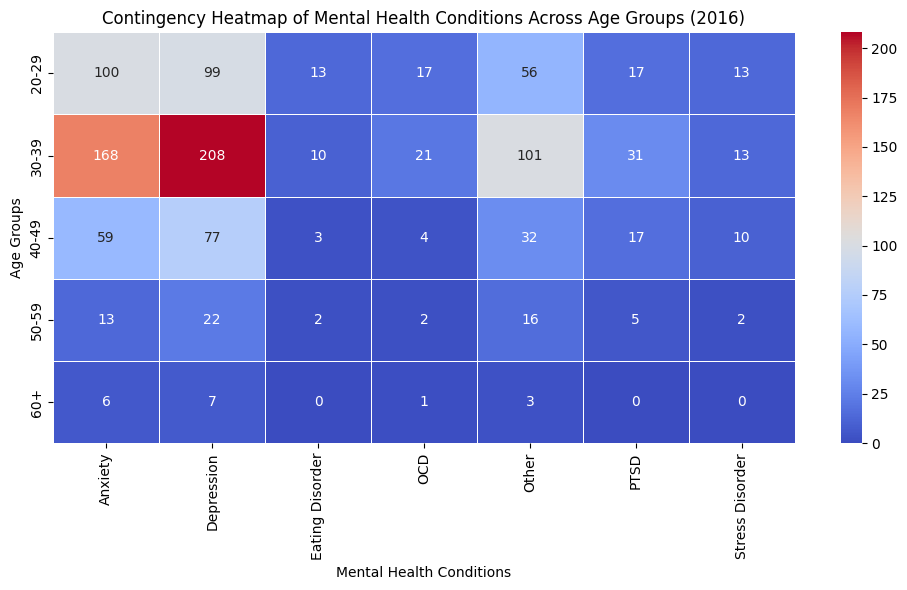

In [41]:
contingency_table = generate_age_conditions_contingency_heatmap_2016(
    db_path, merged_df, condition_mapping
)



Key observations :

- Younger respondents (20-29, 30-39) have the highest reported cases of mental health conditions.

- Anxiety and Depression are the most common conditions across all age groups.

- PTSD and Eating Disorders are more frequent in younger age groups.

- Older age groups (50-59, 60+) report significantly fewer cases across all conditions.


Insights :

1. Depression and Anxiety show the highest prevalence across all age groups**, peaking in the 30-39 range.
2. OCD and Eating Disorders appear more frequently in younger age groups**, with numbers declining in older groups.
3. PTSD is notable in the younger demographics but drops significantly in older adults.



Since there's majority of 20-29 and 30-39 in total, let's normalize the results :

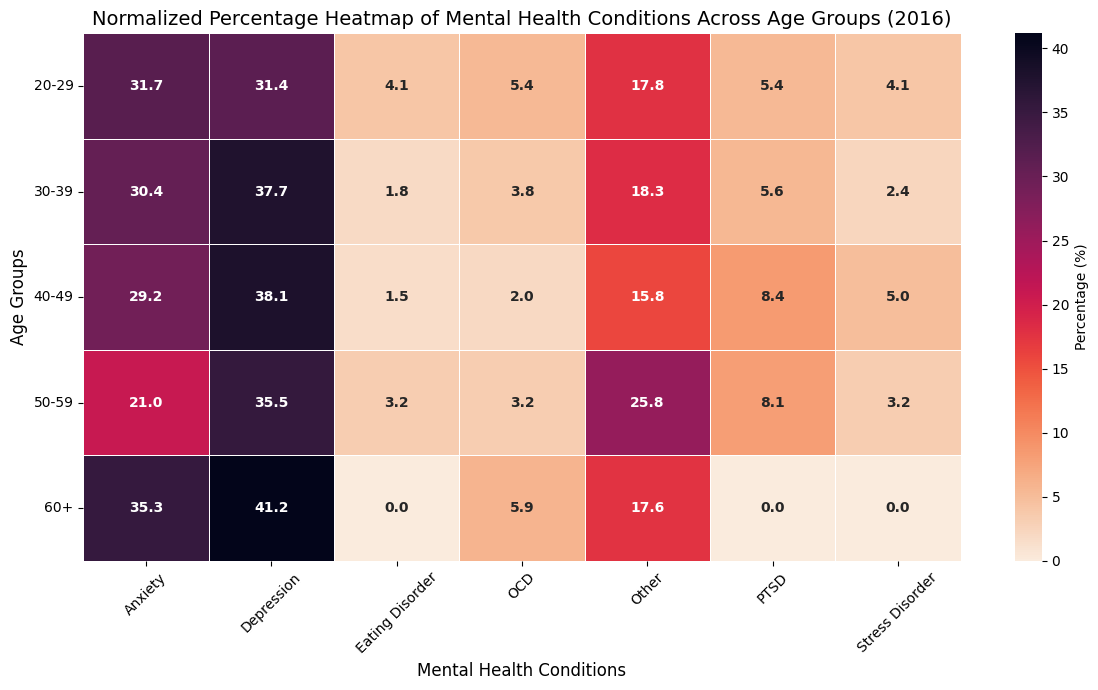

Category,Anxiety,Depression,Eating Disorder,OCD,Other,PTSD,Stress Disorder
Age Group,,,,,,,
20-29,31.746032,31.428571,4.126984,5.396825,17.777778,5.396825,4.126984
30-39,30.434783,37.681159,1.811594,3.804348,18.297101,5.615942,2.355072
40-49,29.207921,38.118812,1.485149,1.980198,15.841584,8.415842,4.950495
50-59,20.967742,35.483871,3.225806,3.225806,25.806452,8.064516,3.225806
60+,35.294118,41.176471,0.000000,5.882353,17.647059,0.000000,0.000000


In [42]:
normalized_contingency_table_2016 = generate_normalized_age_conditions_heatmap_2016(
    db_path, merged_df, condition_mapping
)

normalized_contingency_table_2016

Key insights:

Depression is the most frequently reported condition across all age groups, peaking at 41.18% in the 60+ age group.

Anxiety maintains a consistent presence, highest among 60+ respondents (35.29%) and those aged 20-29 (31.75%).

PTSD peaks in the 40-49 (8.42%) and 50-59 (8.06%) age groups.

Eating Disorders are more commonly reported in the 20-29 age group (4.13%), while they disappear in the 60+ group.

Other Conditions are most prevalent among respondents aged 50-59 (25.81%).

Results highlights :

All age groups suffers from Depression and Anxiety the most, compared to other conditions.

60+ group, even if very small in number itself, struggles  with Depression and Anxiety the most.

20-29 group has highest Eating disorder rate.

50-59 age groups deals with highest percentage of Other mental conditions, highlighting the variety of 'niche' mental conditions they deal with it.

I want to take a deeper dive to gender and mental conditions connections by respondants who expect negative stigma from their coworkers . First let's calcute, how many Men, Women and Other gender group were in 2016 survey in total :

In [43]:
gender_counts_2016 = count_unique_genders_2016(db_path)

print(gender_counts_2016)

{'Male': np.int64(1057), 'Female': np.int64(336), 'Other': np.int64(13)}


The men makes the largest part, while Other gender group have only 13 respondants. Let's see what mental conditions each of the gender group face :

In [44]:
men_conditions_2016 = count_men_conditions_2016(db_path, condition_mapping)
print("Men Conditions in 2016:", men_conditions_2016)

Men Conditions in 2016: {'Anxiety': 214, 'Depression': 243, 'OCD': 28, 'PTSD': 36, 'Eating Disorder': 10, 'Stress Disorder': 27, 'Other': 138}


In [45]:
women_conditions_2016 = count_women_conditions_2016(db_path, condition_mapping)
print("Women Conditions in 2016:", women_conditions_2016)

Women Conditions in 2016: {'Anxiety': 115, 'Depression': 146, 'OCD': 12, 'PTSD': 28, 'Eating Disorder': 16, 'Stress Disorder': 7, 'Other': 59}


In [46]:
other_gender_conditions_2016 = count_other_gender_conditions_2016(
    db_path, condition_mapping
)
print("Other Gender Conditions in 2016:", other_gender_conditions_2016)

Other Gender Conditions in 2016: {'Anxiety': 7, 'Depression': 9, 'OCD': 1, 'PTSD': 1, 'Eating Disorder': 1, 'Stress Disorder': 2, 'Other': 2}


Let's visualize data in the multibar graph :

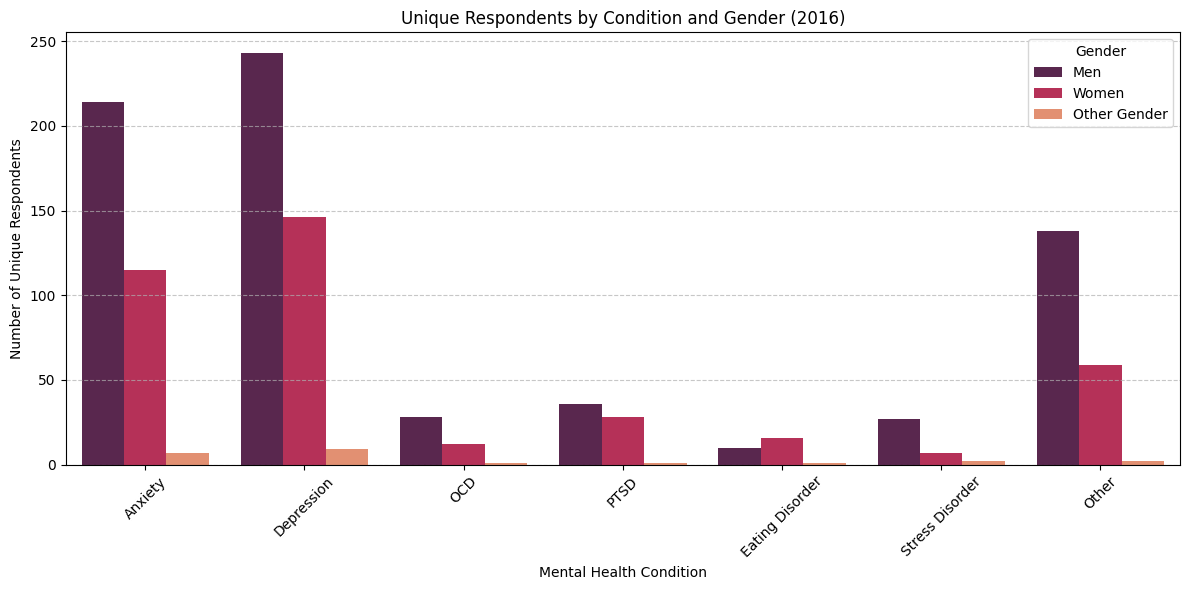

In [47]:
men_conditions_2016 = count_men_conditions_2016(db_path, condition_mapping)
women_conditions_2016 = count_women_conditions_2016(db_path, condition_mapping)
other_gender_conditions_2016 = count_other_gender_conditions_2016(
    db_path, condition_mapping
)

plot_multibar_conditions_2016(
    men_conditions_2016, women_conditions_2016, other_gender_conditions_2016
)

The results indicates that men suffers most from all mental conditions (except eating disorder), but we need to keep in mind that there most men respondants overall. We need to normalize results to see the clearer picture :

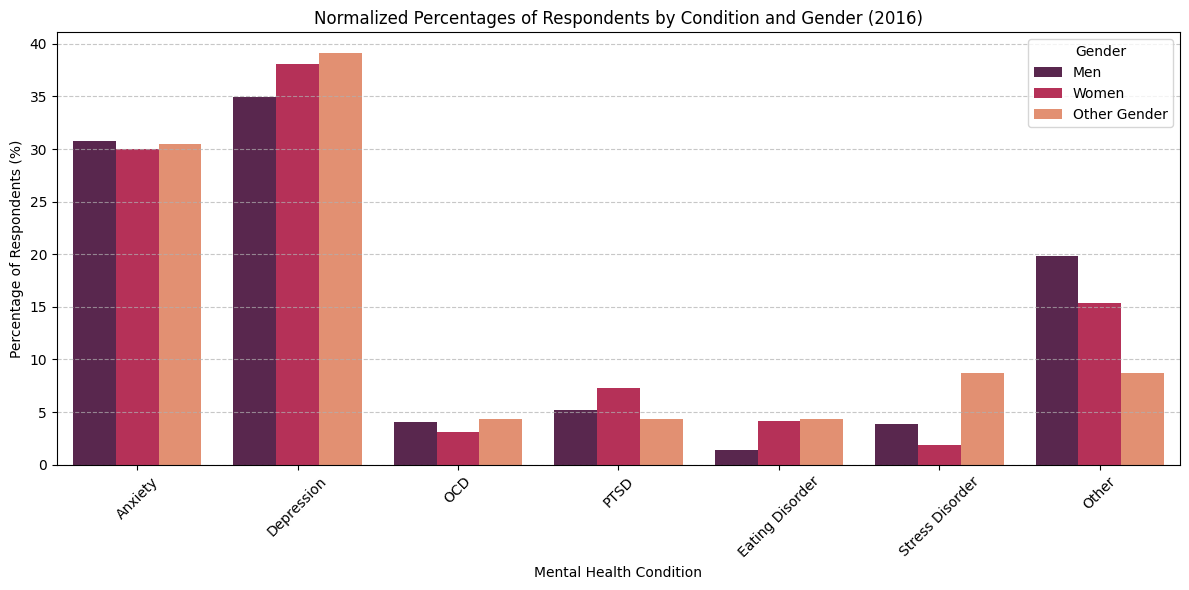


Normalized Percentages by Condition and Gender (2016):

Men:
  Anxiety: 30.75%
  Depression: 34.91%
  OCD: 4.02%
  PTSD: 5.17%
  Eating Disorder: 1.44%
  Stress Disorder: 3.88%
  Other: 19.83%

Women:
  Anxiety: 30.03%
  Depression: 38.12%
  OCD: 3.13%
  PTSD: 7.31%
  Eating Disorder: 4.18%
  Stress Disorder: 1.83%
  Other: 15.40%

Other Gender:
  Anxiety: 30.43%
  Depression: 39.13%
  OCD: 4.35%
  PTSD: 4.35%
  Eating Disorder: 4.35%
  Stress Disorder: 8.70%
  Other: 8.70%



In [48]:
plot_multibar_conditions_percentage_2016(
    men_conditions_2016, women_conditions_2016, other_gender_conditions_2016
)

Key findings and summary of gender based results of 2016 diagnosed respondants who expects negative reaction of their coworkers (if they knew they were diagnosed) :

Women exhibit the highest percentage of PTSD among all groups. Additionally, they are significantly more likely than men to report Eating Disorders. Women are 1.6 times more likely to report an Eating Disorder compared to men, they also report PTSD 1.41 times more often than men

Men report the highest percentages of Depression and Anxiety. They also experience a highest share of Other mental health conditions, highlighting a broader range of challenges beyond the most commonly reported diagnoses. Men  are 1.29 times more likely to report "Other" mental health conditions compared to women (19.83% vs. 15.40%), and nearly 2.3 times more likely than Other Gender respondents (19.83% vs. 8.70%). These "Other" conditions often include less commonly reported or unspecified issues such as substance use disorders, sleep disorders, and mood disturbances not classified under Depression or Anxiety.

Respondents of Other gender (non- binary f.e.) show a more evenly distributed prevalence across mental health conditions. While Depression and Anxiety remain the most commonly reported, they also experience notably higher proportions of Stress Disorders and Eating Disorders compared to men and women. Almost 40% of Other gender respondants reported Depression which are the highest percentage of mental condition in any gender group.

Across all gender groups  Anxiety and Depression are the most commonly reported mental health conditions. 

## Analysis Conclusion

A lot people struggle with mental health in the technology sector. In some cases demographic impacts plays a big role.

**What percentage of individuals working in the technology sector has mental health disorders?**
Around 41.8% of respondents answered Yes to currently having a mental health disorder, while 32.8% answered No, and the remaining were uncertain.

**Is there a link between location (country, state) and the mental conditions reported?**
Among countries with reasonable sample, we can tell that there way more cases of US workers who are having mental disorder compared to EU countries where mojority of people had no mental disorders. This might due workplace cultural differences between EU countries and USA.

**How do mental health conditions numbers vary across different gender groups?**
Overall the Other gender identities show a highest rate (62.9% Yes) and is the most vulnerable group in term of mental disorders across gender groups on average.
Women report the highest rate of currently having a mental health disorder (54.6% Yes) among traditional genders.
Men report lower rates (35.8% Yes).

**Which age are the most likely to have mental disorder?** The likelihood of having a mental health disorder increases with age, peaking in the 60+ group (47.1%). Older groups are more certain about their mental health status, while younger groups show greater uncertainty.

**Is there much of negative stigma overall in the workplaces towards mental conditions?**
Yes. Approximately 31.1% of diagnosed respondents expect negative reactions from coworkers if their mental health condition is known. Additionally, 41.2% are unsure, reflecting ongoing workplace stigma concerns.

**What are the most popular mental conditions among employees? Are these conditions types can be affected by demografic factors?**

We can't tell the results of a majority of tech sector workers, but among those who have a mental condition and expect negative workplace stigma, the most popular conditions were :

Depression (reported by 74.2%).

Anxiety (59.8%).

Other conditions like PTSD, OCD, and Eating Disorders are less common, but still present.

The different type of mental conditions of this specific group had similar pattern across a global countries and states of the US, meaning no visible link between location and specific mental conditions were discovered.

Gender factor was more visible since more Women reported cases of PTSD and Eating Disorders. Men, on the other hand, reported a higher percentage of Other conditions. This category includes less common or rarer mental health conditions, suggesting that men are more likely to deal with mental health issues that are less frequently diagnosed or discussed.

All age groups suffers from Depression and Anxiety the most, compared to other conditions. 60+ group, even if very small in number itself, struggles  with Depression and Anxiety the most.
20-29 group has highest Eating disorder rate. 30-39 peak with most cases of Depression in total.



## Thoughts On How This Analysis Could Be Better

Use more questions data. Majority of my data on mental health being were based on answers of few question even though there a lot of unique question I could deepen my analysis.

Improved data categorization. It would enhance the accuracy of the analysis. In my study, there were two "Other" groups: one for gender identities outside the traditional male/female categories and another for less common mental conditions. Further exploring and refining the categorization of these groups could provide a clearer understanding of these populations and improve the overall precision of the analysis.

Cross-referencing with external Studies. Comparing my findings with external research or literature could help validate my analysis and provide a broader context for results and conclusions.

Incorporating Statistical Significance. Integrate statistical tests (e.g., chi-square, t-tests) to determine if the differences between groups (e.g., gender, age,) are statistically significant. This would strengthen the reliability of my findings.